In [20]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

np.random.seed(42)  # reproducible

def accuracy(preds: np.ndarray, targets: np.ndarray) -> float:
    pred_labels = (preds >= 0.5).astype(int)
    return (pred_labels == targets).mean()

In [21]:
# Activation functions and derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dsigmoid(a):  # derivative in terms of activation a = sigmoid(z)
    return a * (1 - a)

def dtanh(a):  # derivative in terms of activation a = tanh(z)
    return 1 - a**2

def tanh_act(z):
    return np.tanh(z)

In [22]:
def train_xor(hidden_activation: str = 'sigmoid', epochs: int = 8000, lr: float = 1.0) -> dict:
    """
    Train a 2-2-1 network on XOR. Returns a dict with weights, biases, history and helpers.
    hidden_activation: 'sigmoid' or 'tanh' (applies to hidden layer only)
    """
    n_samples = X.shape[0]

    # initialize weights (small random numbers)
    W1 = np.random.randn(2, 2) * 0.5
    b1 = np.random.randn(1, 2) * 0.5
    W2 = np.random.randn(2, 1) * 0.5
    b2 = np.random.randn(1, 1) * 0.5

    losses = []

    for epoch in range(epochs):
        # ---- forward pass ----
        Z1 = X.dot(W1) + b1  # shape (4,2)
        if hidden_activation == 'sigmoid':
            A1 = sigmoid(Z1)
            dA1_from_act = dsigmoid
        elif hidden_activation == 'tanh':
            A1 = tanh_act(Z1)
            dA1_from_act = dtanh
        else:
            raise ValueError("hidden_activation must be 'sigmoid' or 'tanh'")

        Z2 = A1.dot(W2) + b2  # shape (4,1)
        A2 = sigmoid(Z2)  # output activation always sigmoid (0..1)

        # ---- loss (MSE) ----
        loss = np.mean((A2 - y)**2)
        losses.append(loss)

        # ---- backward pass (batch) ----
        # dLoss/dA2 for MSE: (2/N) * (A2 - y)
        dA2 = (2.0 / n_samples) * (A2 - y)  # shape (4,1)
        dZ2 = dA2 * dsigmoid(A2)  # shape (4,1)

        dW2 = A1.T.dot(dZ2)  # (2,4) dot (4,1) -> (2,1)
        db2 = np.sum(dZ2, axis=0, keepdims=True)  # (1,1)

        dA1 = dZ2.dot(W2.T)  # (4,1) dot (1,2) -> (4,2)
        dZ1 = dA1 * dA1_from_act(A1)  # elementwise (4,2)

        dW1 = X.T.dot(dZ1)  # (2,4) dot (4,2) -> (2,2)
        db1 = np.sum(dZ1, axis=0, keepdims=True)  # (1,2)

        # ---- gradient descent update ----
        W2 = W2 - lr * dW2
        b2 = b2 - lr * db2
        W1 = W1 - lr * dW1
        b1 = b1 - lr * db1

        # optional small printouts
        if (epoch + 1) % 2000 == 0:
            print(f"Epoch {epoch+1}/{epochs}  loss={loss:.6f}")

    # final forward for returning predictions
    Z1 = X.dot(W1) + b1
    A1 = sigmoid(Z1) if hidden_activation == 'sigmoid' else tanh_act(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = sigmoid(Z2)

    return {
        'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,
        'losses': np.array(losses),
        'pred': A2, 'hidden_act': A1
    }


In [23]:
# Train with sigmoid hidden activation
res_sig = train_xor(hidden_activation='sigmoid', epochs=8000, lr=1.0)
print('\nTraining complete (hidden: sigmoid)')
pred_sig = res_sig['pred']
acc_sig = accuracy(pred_sig, y)
print(f"Final loss: {res_sig['losses'][-1]:.6f}, accuracy: {acc_sig*100:.1f}%")


Epoch 2000/8000  loss=0.005149
Epoch 4000/8000  loss=0.001130
Epoch 6000/8000  loss=0.000614
Epoch 8000/8000  loss=0.000418

Training complete (hidden: sigmoid)
Final loss: 0.000418, accuracy: 100.0%


In [24]:
# Train with tanh hidden activation
res_tanh = train_xor(hidden_activation='tanh', epochs=8000, lr=1.0)
print('\nTraining complete (hidden: tanh)')
pred_tanh = res_tanh['pred']
acc_tanh = accuracy(pred_tanh, y)
print(f"Final loss: {res_tanh['losses'][-1]:.6f}, accuracy: {acc_tanh*100:.1f}%")


Epoch 2000/8000  loss=0.125536
Epoch 4000/8000  loss=0.125237
Epoch 6000/8000  loss=0.125151
Epoch 8000/8000  loss=0.125110

Training complete (hidden: tanh)
Final loss: 0.125110, accuracy: 50.0%


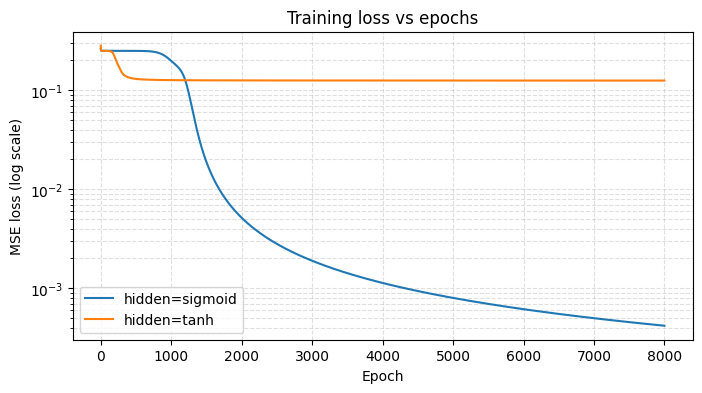

In [25]:
# Plot loss curves for both runs
plt.figure(figsize=(8,4))
plt.plot(res_sig['losses'], label='hidden=sigmoid')
plt.plot(res_tanh['losses'], label='hidden=tanh')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss (log scale)')
plt.title('Training loss vs epochs')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

In [26]:
# Display final weights and accuracies and predictions for both models
def show_results(res, name):
    print(f'--- Results ({name}) ---')
    print('W1:\n', res['W1'])
    print('b1:\n', res['b1'])
    print('W2:\n', res['W2'])
    print('b2:\n', res['b2'])
    preds = (res['pred'] >= 0.5).astype(int)
    print('\nPredictions (probabilities):\n', np.round(res['pred'], 4).T)
    print('Predicted labels:\n', preds.T)
    print('True labels:\n', y.T)
    print('Accuracy: ', accuracy(res['pred'], y))

show_results(res_sig, 'hidden=sigmoid')
print()
show_results(res_tanh, 'hidden=tanh')


--- Results (hidden=sigmoid) ---
W1:
 [[6.34476322 4.49002232]
 [6.37296932 4.49692595]]
b1:
 [[-2.80955388 -6.89652129]]
W2:
 [[ 9.29983456]
 [-9.98555958]]
b2:
 [[-4.29268765]]

Predictions (probabilities):
 [[0.0224 0.9805 0.9805 0.0202]]
Predicted labels:
 [[0 1 1 0]]
True labels:
 [[0. 1. 1. 0.]]
Accuracy:  1.0

--- Results (hidden=tanh) ---
W1:
 [[ 2.45271461 -1.6776774 ]
 [-5.25018194 -5.05916727]]
b1:
 [[-1.93026603  0.44167926]]
W2:
 [[ 3.66242158]
 [-3.42473071]]
b2:
 [[0.23760521]]

Predictions (probabilities):
 [[0.0091 0.4998 0.9925 0.5001]]
Predicted labels:
 [[0 0 1 1]]
True labels:
 [[0. 1. 1. 0.]]
Accuracy:  0.5


## Interpretation and notes

- Training this tiny network on XOR is a classic exercise showing that a single hidden layer with nonlinearity can solve a non-linearly separable problem.
- We compared `sigmoid` vs `tanh` for the hidden layer (output uses `sigmoid` because targets are 0/1).
- Because the dataset is tiny (4 points), training uses full-batch gradient descent. The learning rate is intentionally large (1.0) as requested — small random initialization keeps updates stable here.
- The loss plot (log-scale) shows how quickly each activation reaches a low MSE. Depending on initialization and random seed, one activation might converge faster.

